In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import re

PValue=.01

Folders with Files in them

In [32]:
plugged_in_no_brower_7_20_22 = 'Plugged_In_No_Browser_7-20-22' # 10 runs each no enough for statistics
plugged_in_no_brower_7_21_22 = 'Plugged_In_No_Browser_7-21-22' # 50 runs each
plugged_in_with_brower_7_26_22 = 'Plugged_In_With_Browser_7-26-22' # 50 runs attemptings to see slow downs with new
                                                                   # functionality to show processor speeds

battery_two_test_at_once_7_27_22 = 'Battery_Two_Test_At_Once_7_27_22' # Ran two tests at once to test output 
                                                                      # of cpu speed outputs

currentPath = battery_two_test_at_once_7_27_22

Search transcript files and process their contents for patterns and programs runs, iterations start and end, and cpu speed throttling changes.

In [33]:
with open(currentPath+'/' + 'transcript1.txt') as f:
    lines = f.readlines()

f.close()
start_of_sections = []
speed_changes = []
start_of_iterations = []
end_of_iterations = []

find_prog_patt = '(pexl|lpeg|rosie).* (\\w+) +\\d+'
searcher = re.compile(find_prog_patt)

for i in range(0,len(lines)):
    line = lines[i]
    
    if line.find('Benchmark') > -1:
        match = searcher.search(line)
        assert len(match.groups() ) == 2,('Matched to many things in the pattern identifier '+match.groups())
        line = match.groups()[1]+'_'+match.groups()[0]
        start_of_sections.append( (line,i) )
        print(line,' ',i)
    elif line.find('CPU_Speed_Limit') > -1:
        speed_changes.append( (line,i) )
    elif line.find('Running') > -1:
        start_of_iterations.append( (line,i) )
    elif line.find('Done.') > -1:
        end_of_iterations.append( (line,i) )



abram_lpeg   12
abram_pexl   898
abram_rosie   1427
longword_lpeg   2076
longword_pexl   89514


In [34]:
malformed_start_point = start_of_sections[4][1] #The laptop ran out of battery and shut down during this test. This
                                                # resulted in data sections that were to poorly formated for 
                                                # recovery. 

In [35]:
# This section reads the value the speed was changed to from the string. It could be combined with the above section
# to make the code more concise. If we pursue reading the data from transcripts I will do that.
speed_limit_pattern = ' (\\d+)\n'
speed_limit_searcher = re.compile(speed_limit_pattern)

speed_changes_two = []

for occurence in speed_changes:
    if occurence[1] > malformed_start_point:
        continue
    temp = occurence[0]
    #print(occurence)
    match = speed_limit_searcher.search(temp)
    if match is None:
        print('ignoring line ', occurence[1])
        continue
    assert len(match.groups() ) == 1,'Matched to many things looking for speed limit changes'
    temp = match.groups()[0]
    speed_changes_two.append( (int(temp),occurence[1]))


In [36]:
speed_changes = speed_changes_two

In [37]:
# Removing the data that is to malformed for use. 
# This bit also stitches the start and end of each iteration together. together. Because of the malformed section the start and end lists don't have
#   equal lengths and so the inbuilt stich function can't be used.
iterations_two = []

for i in range(0,len(start_of_iterations)):
    
    if start_of_iterations[i][1] > malformed_start_point:
        continue
    iterations_two.append( (start_of_iterations[i][1],end_of_iterations[i][1]) )
print('Before partitioning bad data we had ',len(start_of_iterations))
print('Now we have ',len(iterations_two))

Before partitioning bad data we had  472
Now we have  420


In [38]:
# Idea - First loop looks to consume any speed changes that happen in between iterations then loops to add intra
#         speed changes to a list. One important assumption is that starting speed is 100. Could implement a check
#          to ensure that's true but not sure it ever isn't.

current_speed_idx = 0
current_speed = 100
runs_w_speed = []

for entry in iterations_two:
    temp_speeds = []
    
    start_current_entry_loc = entry[0] # 1st element in tuple is start index of iteration
    end_current_entry_loc = entry[1]   # 2nd entry in tuple is end index of iteration
    current_speed_loc = speed_changes[current_speed_idx][1] # 2nd index of tuple is current cpu_speed_limit
    
    # Inter Loop - consume and update speed to be the last change before the start of current iteration
    while start_current_entry_loc > current_speed_loc:
        current_speed_idx += 1
        current_speed_loc = speed_changes[current_speed_idx][1]
        current_speed = speed_changes[current_speed_idx-1][0]
    
    # Intra Loop - append most recent speed to list, update speed and repeat until we find a speed change
    #               after end of current iteration
    while end_current_entry_loc > current_speed_loc:
        temp_speeds.append( current_speed )
        current_speed_idx += 1
        current_speed_loc = speed_changes[current_speed_idx][1]
        current_speed = speed_changes[current_speed_idx-1][0]
        
    # This ensures that the speed list isn't empty and that if there are no changes it has the most recent speed
    temp_speeds.append(current_speed)
    
    # This series of if/else attaches the appropriate pattern/program name to each iteration.
    # This logic isn't great but not sure how to clean it up
    if start_current_entry_loc < start_of_sections[1][1]:
        name = start_of_sections[0][0]
    elif start_current_entry_loc < start_of_sections[2][1]:
        name = start_of_sections[1][0]
    elif start_current_entry_loc < start_of_sections[3][1]:
        name = start_of_sections[2][0]
    elif start_current_entry_loc < start_of_sections[4][1]:
        name = start_of_sections[3][0]
    
    runs_w_speed.append( (name,entry,temp_speeds.copy()) )

Importing Raw Data

In [39]:
# This sections removes duplicate consecutive outputs from a bug in the data generating program.
#  Each hyperfine loop instantiated a version of the speed monitor but didn't ever close it. Then when the 2nd loop
#  started, Longword pattern, each speed monitor instance was reporting the data. Thus double reports of the 
#  same data. This goes through and pops all those double reports.

for run in runs_w_speed:
    if len(run[2]) > 1:
        counter = len(run[2])-1
        i = 0
        while i < counter:
            if run[2][i] == run[2][i+1]:
                run[2].pop(i+1)
                counter += -1
                i += -1
            i += 1
min_speed = min(runs_w_speed[0][2])

for run in runs_w_speed:
    if min(run[2]) < min_speed:
        print(min_speed,run[0:2])
        min_speed = min(run[2])
runs_w_speed[0]

100 ('abram_lpeg', (40, 55))
93 ('longword_lpeg', (2984, 10219))
39 ('longword_lpeg', (54364, 66099))


('abram_lpeg', (16, 19), [100])

In [40]:

lpeg_Abram_Speed = []
Pexl_Abram_Speed = []
Rosie_Abram_Speed = []
lpeg_Longword_Speed = []

# This creates a dictionary containing each of the pattern/program combos found in the transcript file. Keys are
#  the pattern_program name and values are a list lists of the "cpu speed" for each iteration whose "name" 
#  matchs the key.
Speed_Dic ={}
patterns_identified = []
for item in start_of_sections:
    patterns_identified.append(item[0])
    Speed_Dic[item[0]] = []

for pattern in patterns_identified:
    for run in runs_w_speed:
        name = run[0]
        if name.find(pattern) != -1:
            Speed_Dic[pattern].append(run[2])


In [41]:
# This creates a dictionary whose keys are the pattern_program combo found in the transcript. The values are a 
#  two dimensional dataframe. 1 column is the duration of each iteration. 2nd column is a list of the "cpu speed/s"
#  during that iteration.

DF_Dic ={}

folder_path = currentPath +'/'
whats_inside = os.listdir(currentPath)
colors = ['green','blue','red']

for file in whats_inside:
    if file.find('~') > -1:
        continue
    elif file.find('.DS_Store') > -1:
        continue
    elif file.find('#') > -1:
        continue
    elif file.find('.txt') > -1:
        continue
    
    print(file)
    name_pattern = file.split('-')[0]
    assert file.find('.json') != -1, ('Trying to read a non .json file '+file)
    temp = pd.read_json(folder_path+file, orient = 'records')
    
    progNames = []
    for j in range(0,temp.shape[0]):
        command = temp.iloc[j,0]['command']
        
        if command.find('lpeg') != -1:
            found_prog = 'lpeg'
        elif command.find('pexl') != -1:
            found_prog = 'pexl'
        elif command.find('rosie') != -1:
            found_prog = 'rosie'
        
        tempDF = pd.DataFrame(columns = [found_prog,found_prog+'_Speed'])
        tempDF[found_prog] = temp.iloc[j,0]['times']
        warmup_runs = len(Speed_Dic[name_pattern+'_'+found_prog]) - tempDF[ found_prog ].size
        # There are 5 warm-up iterations before each run is recorded. These warmups are in the transcript but not 
        #  the actual data.
        print('Found ',warmup_runs,' warm up runs.')
        tempDF[found_prog+'_Speed'] = Speed_Dic[name_pattern+'_'+found_prog][warmup_runs:]
        
        DF_Dic[name_pattern+'_'+found_prog] = tempDF.copy()

longword-captureAll.json
Found  5  warm up runs.
abram-captureAll.json
Found  5  warm up runs.
Found  5  warm up runs.
Found  5  warm up runs.


Function to calculate bandwidth value from data assuming bimodal distrobution

In [42]:
# Magic number comes from the wiki article on kde and how to estimate bandwidth from the data.
# The wiki article suggested .9 as a good approximation for bimodal/multimodal distrubutions.
def band_est(dataSet):
    magic_num = .9
    n = len(dataSet)
    samp_std = dataSet.std()
    q1 = np.quantile(dataSet,.25)
    q3 = np.quantile(dataSet,.75)
    IQR = q3-q1
    bandwidth_estimate = magic_num * min(samp_std,IQR/1.34)*n**(-1/5)
    return bandwidth_estimate

Funtion to calculate and plot the kde graphs 

In [43]:
def kde_graph(data,title):
    dataArray = data[:,0].reshape(-1,1)
    band_estimate = band_est(dataArray)
    kde = KernelDensity(kernel='gaussian', bandwidth= band_estimate ).fit(dataArray)
    s = np.linspace(min(dataArray)[0],max(dataArray)[0],10000)
    e = kde.score_samples(s.reshape(-1,1))
    
    if title.find('lpeg') != -1:
        color = 'green'
    elif title.find('rosie') != -1:
        color = 'red'
    elif title.find('pexl') != -1:
        color = 'blue'
    else:
        color = 'black'
    
    plt.plot(s, e, c = color)
    plt.axhline(y=0)
    
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    #print("Minima: X:", s[mi],'\n        Y:', e[mi], '\n')
    #print("\nMaxima: X:", s[ma],'\n        Y:', e[ma],'\n')
    
    #if min(e[mi]) < -100:
    #    plt.yscale('symlog')
    
    mean = np.mean(dataArray)
    median = np.median(dataArray)
    
    for points in data:
        temp = np.mean(points[1])
        if temp < 100:
            
            norm = points[0]-min(dataArray)[0]
            
            stepSize = (max(dataArray)[0] - min(dataArray)[0])/10000
            
            dif = round( norm/stepSize) -1
            
            plt.scatter(points[0],e[dif], c ='purple',)
            
    plt.vlines(x=mean,ymin = min(e), ymax = max(e), colors = 'grey')
    plt.vlines(x=median,ymin = min(e), ymax = max(e), colors = 'teal')
    
    plt.title((title+' '+str(round(dataArray.std(),3) ) ) )
    plt.show();
    return (s[mi],e[mi]),(s[ma],e[ma])

In [50]:
def scale_speed(data):
    temp = data.copy()
    assert data.shape[1] == 2, 'Data has more/less columns than 2'
    assert type(data.iloc[0,1]) == list, 'Second column is not a list'
    
    for row in temp.index:
        if np.mean(temp.iloc[row,1]) < 100:
            #print(temp.iloc[row,0])
            #print(temp.iloc[row,0] * np.mean(temp.iloc[row,1])/100)
            temp.iloc[row,0] = temp.iloc[row,0] * np.mean(temp.iloc[row,1])/100
    return temp

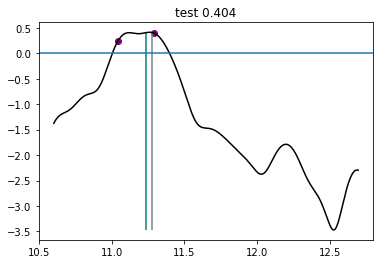

In [52]:
#print(type(DF_Dic['longword_lpeg'].iloc[0,1]))
test = scale_speed(DF_Dic['abram_lpeg'])
kde_graph(test.to_numpy(),'test');

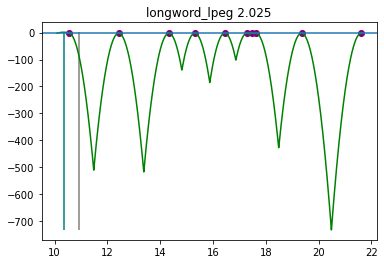

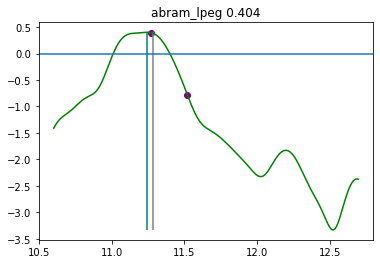

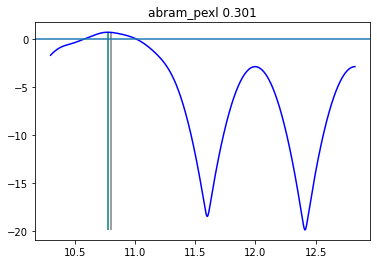

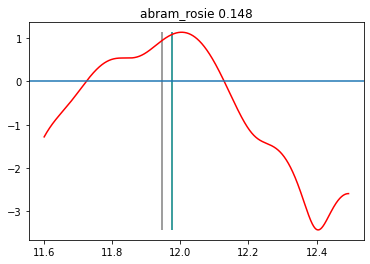

In [15]:
min_max_Dic = {}
for name in DF_Dic.keys():
    min_max_Dic[name] = (kde_graph(DF_Dic[name].to_numpy(),name))
#mi , ma = kde_graph(testing,title,'test')


In [16]:
split_graph_dic = {}

for graph in min_max_Dic:
    mi, ma = min_max_Dic[graph]
    loc_val = zip(mi[0],mi[1])
    temp = []
    prog, name = graph.split('_')
    
    currentDF = DF_Dic[name][prog]
    
    temp.append(currentDF.min())
    
    for val in loc_val:
        if val[1] < 0:
            temp.append(val[0])
    
    temp.append(DF_Dic[name][prog].max())
    
    split_graph_dic[graph] = []
        
    for counter in range(1,len(temp)):
        if counter == len(temp)-1:
            split_graph_dic[graph].append(currentDF[[ test for test in currentDF >= temp[counter-1] ]])
        else:
            temp2 = currentDF[[test for test in currentDF >= temp[counter - 1] ] ]
            split_graph_dic[graph].append(temp2[[test for test in temp2 < temp[counter] ] ])
            
    sum_counter = 0
    for lists in split_graph_dic[graph]:
        sum_counter += len(lists)
    
    assert sum_counter == len(currentDF),('Missing/Double Counted Data in splitting set '+graph)

KeyError: 'lpeg'

Attempting to combine all the data into one set to look at distrobution of clock times.

In [18]:
for graph in split_graph_dic:
    print(graph)
    for lists in split_graph_dic[graph]:
        print(len(lists))

lpeg_Longword
1
90
1
1
1
1
1
1
1
1
1


ValueError: setting an array element with a sequence.

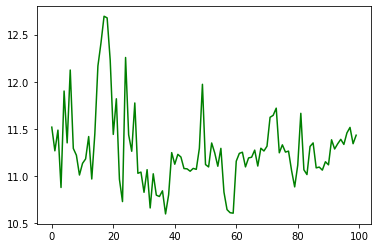

In [19]:
test = 'Abram'
for name in DF_Dic[test].columns:
    if name =='lpeg':
        color = 'green'
    elif name =='Pexl':
        color = 'blue'
    elif name == 'Rosie':
        color = 'red'

    plt.plot(DF_Dic[test][name], color = color)
